In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names-shuffled.txt', 'r').read().splitlines()

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [8]:
context_length = 3 # context length: number of chars used to predict the next char

def build_dataset(words):
    X, Y = [], [] # inputs and labels

    for w in words:
        context = [0] * context_length
        for c in w + '.':
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]] # sliding the context by 1 character to right

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([404063, 3]) torch.Size([404063])
torch.Size([50753, 3]) torch.Size([50753])
torch.Size([50641, 3]) torch.Size([50641])


In [63]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g, requires_grad=True)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g, requires_grad=True)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size), generator=g, requires_grad=True)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [64]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 29.2238
  10000/ 200000: 2.2045
  20000/ 200000: 2.1383
  30000/ 200000: 2.2018
  40000/ 200000: 2.3168
  50000/ 200000: 1.9739
  60000/ 200000: 2.6243
  70000/ 200000: 1.8065
  80000/ 200000: 1.8101
  90000/ 200000: 1.8437
 100000/ 200000: 2.3599
 110000/ 200000: 1.7165
 120000/ 200000: 2.1550
 130000/ 200000: 2.0746
 140000/ 200000: 1.7881
 150000/ 200000: 1.6131
 160000/ 200000: 1.9763
 170000/ 200000: 1.7174
 180000/ 200000: 1.9987
 190000/ 200000: 1.8892


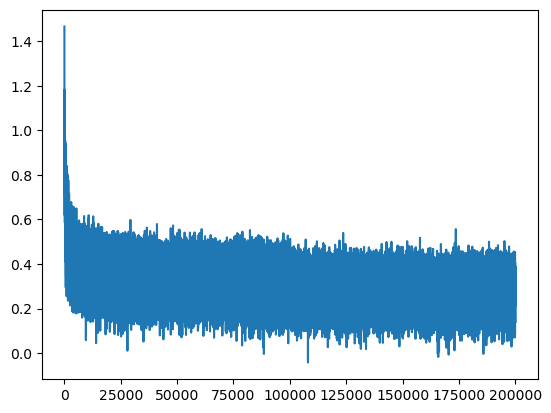

In [65]:
plt.plot(lossi)

In [66]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.9400393962860107
dev 1.9561305046081543


In [67]:
g = torch.Generator().manual_seed(1337101+20)
for _ in range(20):
    context = [0]*context_length
    out = []
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g, replacement=True)
        out.append(itos[ix.item()])
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))

bhati.
thadivyaathevathika.
katheekika.
harsini.
sathudeya.
esha.
archirothikendikannikha.
inthan.
lacheyan.
drlodithth.
ani.
dharth.
balangenth.
ashrayinth.
pooshit.
lika.
iri.
neshkavika.
madwasahanan.
hem.


### Fixing the initial loss

Initially the loss is very high: 0/ 200000: 27.1381 and it rapidly comes down to 2. So, the initial loss is very high.

In training of NN, we can always have a rough idea of what loss to expect at initialization.

At initialization, we don't have any reasons to believe that any character can be more likely than another. The prob distribution that comes out initially is a uniform distribution, assigning almost equal prob to all the 27 characters.

In [40]:
prob = 1/27.0
- torch.tensor(prob).log() # loss is negative log of prob

tensor(3.2958)

NLL of uniformly occuring charater is 3.2958 which is much much lesser than the initial loss reported by network i.e. 27.1381. NN is assigning unequal prob to charaters.

In [56]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

When the logits are close to 0, the probs are uniform. If the label is 2 or 3 or any, we'll get exact same loss because the distribution is uniform.

In [47]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

Here we've increased the logits for one of the character, if the same character is the correct one, then the loss will be very low.

In [48]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[3].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(5.0200))

If the logits with high value is not the correct character, then the loss will be very high.

In [53]:
# logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[3].log()
logits, probs, loss

(tensor([-1.5702,  0.8523, -1.0681,  1.2669]),
 tensor([0.0323, 0.3638, 0.0533, 0.5506]),
 tensor(0.5967))

Logits are normally distributed in the above example, which are centered around zero. So, the loss is not very high.

In [55]:
logits = torch.randn(4) *100
probs = torch.softmax(logits, dim=0)
loss = -probs[3].log()
logits, probs, loss

(tensor([  49.9812, -130.6982,   11.6508, -114.2545]),
 tensor([1.0000e+00, 0.0000e+00, 2.2559e-17, 0.0000e+00]),
 tensor(inf))

But if the logits are very far apart as in above example, we might get extremely insane loss, even infinity at initialization.

So, we want the logits to be roughly zero when initializing.

NOTE: Logits don't have to be zero, they just have to be equal. We'll still get same loss as we get when logits are all zeros. But by symmetry we don't want them to be any +ve or -ve numbers, we want them all to be zeros.

Logits are calculated using the weights W2 and biases b2. If we want to make logits closer to zero initially, then we can set b2 to zero and make W2 very small.

In [70]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [71]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h = torch.tanh(emb.view(-1, context_length*n_emb_dim)@W1 + b1) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3382
  10000/ 200000: 2.1798
  20000/ 200000: 2.2680
  30000/ 200000: 2.0886
  40000/ 200000: 2.3178
  50000/ 200000: 2.0846
  60000/ 200000: 2.7025
  70000/ 200000: 1.6936
  80000/ 200000: 1.8562
  90000/ 200000: 1.8268
 100000/ 200000: 1.9872
 110000/ 200000: 1.7483
 120000/ 200000: 2.0838
 130000/ 200000: 2.0767
 140000/ 200000: 1.8027
 150000/ 200000: 1.5521
 160000/ 200000: 1.8047
 170000/ 200000: 1.7415
 180000/ 200000: 2.0092
 190000/ 200000: 1.7618


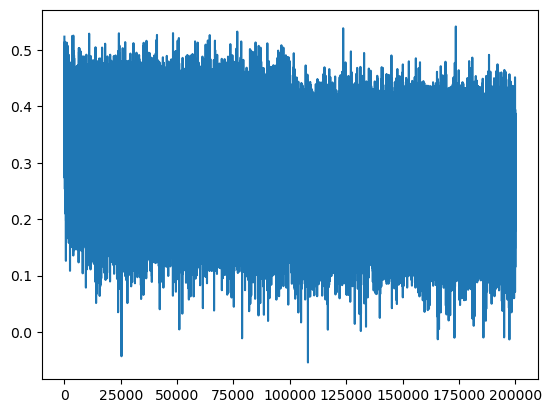

In [72]:
plt.plot(lossi)

No more hockey stick shape, because the initial loss is already realistic (close to what it actually should be).

In [73]:
split_loss('train')
split_loss('dev')
# losses improved a little. We're spending more time optimizing the NN actually, instead of just spending the initial cycles
# squashing down the weights.

train 1.9139963388442993
dev 1.9348492622375488


### Fixing the saturated tanh

In [74]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

g = torch.Generator().manual_seed(1337101)

C = torch.randn((vocab_size, n_emb_dim), generator=g)
W1 = torch.randn((context_length*n_emb_dim, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # close to zero
b2 = torch.randn(vocab_size, generator=g) * 0 # initially zero

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [75]:
epochs = 200000
batch_size = 24
lossi = []
g = torch.Generator().manual_seed(1337101)
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # 24x3x10
    h_pre_activation = emb.view(-1, context_length*n_emb_dim)@W1 + b1 # 24x200
    h = torch.tanh(h_pre_activation) # 24x200
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 100000 else 0.01  
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3382


In [79]:
h

tensor([[-1.0000,  0.9708, -0.6382,  ..., -0.9783,  0.9693, -0.9985],
        [-1.0000,  0.7690,  1.0000,  ..., -0.9999,  0.9838, -1.0000],
        [ 0.9999, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  0.9965],
        ...,
        [-1.0000,  1.0000,  0.7552,  ..., -1.0000,  1.0000, -0.7790],
        [-0.9994, -0.9991,  0.1907,  ..., -0.9984,  0.6924, -1.0000],
        [ 1.0000, -0.2758, -1.0000,  ...,  0.2693,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

Most of the values here are -1 or 1. tanh is a squashing function, it takes a value and squash it between -1 and 1

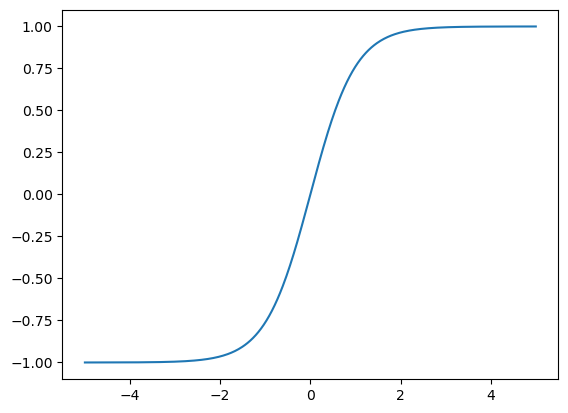

In [84]:
x = torch.linspace(-5, 5, 500)
plt.plot(x, torch.tanh(x));

torch.Size([24, 200])


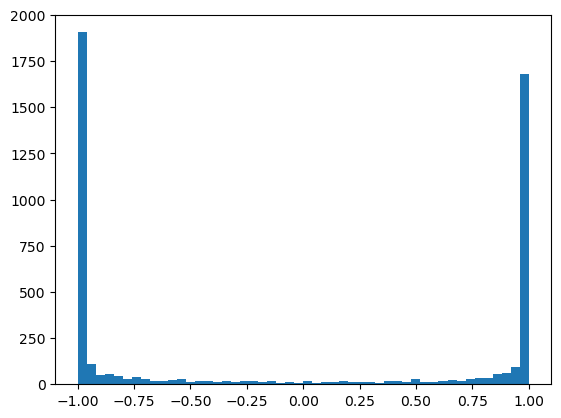

In [87]:
print(h.shape)
x = h.view(-1).tolist() # creating a single large list of h
plt.hist(x, bins=50);

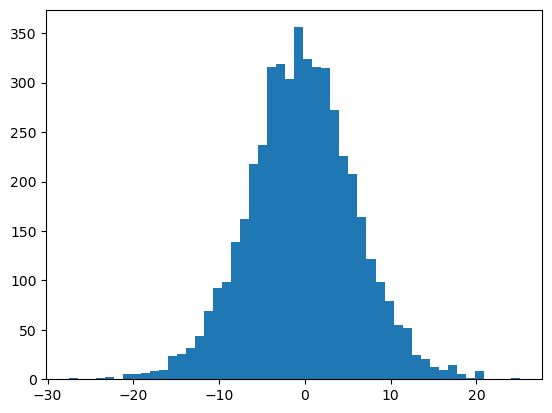

In [89]:
plt.hist(h_pre_activation.view(-1).tolist(), 50);

After applying tanh on h_pre_activation, most of the values take on -1 and +1. It is because in h_pre_activation the values are very broad, they are between -20 and +20 and applying tanh make these values -1 and +1

What happens to the gradients when the tanh is very close to -1 or +1?

    self.grad += (1.0 - tanh(x)**2) * out.grad

Whenever tanh(x) takes values closer to -1 or 1, the grad is almost zero and we're stopping the backpropagation through this tanh unit (out.grad won't propagate further).

When tanh(x) is zero, the out.grad passes as it is. This unit is sort of inactive and the gradient just passes through.

If you notice, the amount of out.grad always decreases ((1.0 - tanh(x)^2) * out.grad) when passed through tanh unit and it decreases perportionally to where you're in the tanh region. When you're in flat region (1.0 - tanh(x)^2) is close to zero and when in the slope region it is between 0 to 0.9999. 

In the flat regions of tanh, the derivative is close to zero, there's no impact on the loss on changing the weights of this perticular neuron.


